# POPPY Simulation: MagAO-X for PDR (All Focal Planes Corrected)
## Most Recent Status Note:
<b>2017/03/17</b> Corrected focal point location for telescope F/11 and MagAO-X F/# (F/16, F/57, F/69, science F/69) focal points. Happy St. Paddy's Day!

In [29]:
%matplotlib inline
#load modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy import units as u
from astropy.io import fits
from  matplotlib.colors import LogNorm 
#POPPY
import poppy
from poppy.poppy_core import PlaneType
print("POPPY Version: "+poppy.__version__)

POPPY Version: 0.6.0rc1


## Initiate the optical elements and variables
- The values for the Magellan telescope (all elements and distances before F/11 focal plane) pulled from Oli Durney's MagAO-X Zemax file.
- MagAO-X values (after F/11 focal plane) pulled from Laird Close's MagAO-X design spreadsheet (January 2017)

### Optical elements not implemented:
- ADC1 (surface 4&5, 7&8)
- ADC2 (surface 6&7, 9&10)

### To-do Tasks:
- Incorporate PSD into POPPY via FITS file (see: https://pythonhosted.org/poppy/api/poppy.FITSOpticalElement.html)
- Add pupil design as secondary obscuration for entrance aperture

In [30]:
# note: u.m is in meters
testWavelength = 656e-9 * u.m # this may change in the future.
npix = 256  # resolution

# physical radius values
M1_radius = 3.239204 * u.m 
M2_radius = 0.632573 * u.m 
#M3_radius = 0.334947 * u.m # Different Zemax files say other values.
M3_radius = 0.439879 * u.m
oap_radius = 0.0254 * u.m # 2 inch diameter OAP
lyot_stop_diam = 0.009 * u.m

# radius of curvature values
M1_roc = 16.26 * u.m
M2_roc = 2.862820 * u.m
fl_M1 = 8.128 * u.m
fl_M2 = M2_roc/2

# propagation distances
d_m1_m2 = 9.72205 * u.m
d_m2_m3 = 9.02279 * u.m
d_m3_f11fp = 4.979516 * u.m 
d_f11fp_oap0 = 0.1434399617 * u.m
d_oap0_woofer = 0.14437519 * u.m
d_woofer_oap1 = 0.2107263437 * u.m
d_oap1_asmfp = 0.2107263437 * u.m
d_asmfp_oap2 = 0.3136327727 * u.m
d_oap2_tweeter = 0.3136327727 * u.m
d_tweeter_oap3 = 1.106254211 * u.m
d_oap3_f57fp = 1.106254211 * u.m
d_f57fp_oap4 = 0.513 * u.m
d_oap4_ttmirror = 0.513 * u.m
d_ttmirror_oap51 = 0.621 * u.m
d_oap51_f69fp = 0.621 * u.m
d_f69fp_oap52 = 0.621 * u.m
d_oap52_lyot = 0.621 * u.m
d_lyot_oap53 = 0.621 * u.m
d_oap53_f69sci = 0.621 * u.m

# OAP mirrors
# All focal lengths are the FS (vertex focus) values in Laird's excel spreadsheet
OAP0 = poppy.QuadraticLens(0.1434399616742 * u.m, name='OAP-0')
OAP1 = poppy.QuadraticLens(0.2107263436959 * u.m, name='OAP-1')
OAP2 = poppy.QuadraticLens(0.3136327726755 * u.m, name='OAP-2')
OAP3 = poppy.QuadraticLens(1.1062542105511 * u.m, name='OAP-3')
OAP4 = poppy.QuadraticLens(0.513 * u.m, name='OAP-4')
OAP5 = poppy.QuadraticLens(0.621 * u.m, name='OAP-5')

M1 = poppy.QuadraticLens(fl_M1, name='M1')
M2 = poppy.QuadraticLens(fl_M2, name='M2')

lyotstop = poppy.CircularAperture(radius=lyot_stop_diam/2, name='Lyot Stop')

## Build Magellan Telescope

In [31]:
magaox = poppy.FresnelOpticalSystem(pupil_diameter=2*M1_radius, 
                                       npix=npix*2,
                                       beam_ratio=.34)#beam_ratio is the oversampling convention used in PROPER

# Entrance Aperture
magaox.add_optic(poppy.CircularAperture(radius=M1_radius))
# Add line of code here for pupil dimensions but need to get more info about spider + center obscuration

# Surface -6: Primary Mirror
magaox.add_optic(M1)
magaox.add_optic(poppy.CircularAperture(radius=M1_radius,name="M1 aperture"))

# Surface -5: Secondary Mirror
magaox.add_optic(M2, distance=d_m1_m2)
magaox.add_optic(poppy.CircularAperture(radius=M2_radius,name="M2 aperture"))

# Surface -4: Tertiary mirror
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="M3 (flat)"), distance=d_m2_m3)
magaox.add_optic(poppy.CircularAperture(radius=M3_radius, name="M3 (flat) aperture"))

# Surface -3: F/11 Focal Plane
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="F/11 focal plane (uncorrected)"), distance=d_m3_f11fp)

### F/11 Focal Plane correction

In [32]:
# Calculate F/11 focal plane correction distance
unfixed_f11fp_psf, unfixed_f11fp_wfs = magaox.calcPSF(wavelength=testWavelength, display_intermediates=False, return_intermediates=True)
f11_last_wave = unfixed_f11fp_wfs[-1]
f11_delta = f11_last_wave.z_w0 - f11_last_wave.z #f11_delta is the change in distance to compensate the gaussian beam waist.

# Incorporate the correction distance to see the F/11 PSF.
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="F/11 focal plane (corrected)"), distance=f11_delta)

Magellan Telescope F/11 Focal Plane correction distance:

In [33]:
f11_delta

<Quantity 0.027078593970912834 m>

### F/11 PSF

In [34]:
matplotlib.rcParams["font.size"]=7
plt.figure(figsize=[6,8])
f11fp_psf, f11fp_wfs = magaox.calcPSF(wavelength=testWavelength, display_intermediates=False, return_intermediates=True)

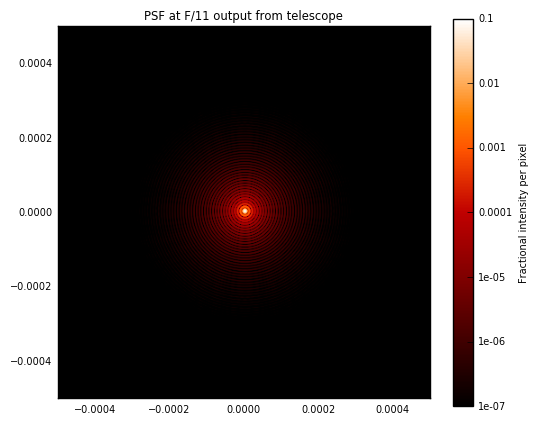

In [35]:
# Check out F/11 focal plane PSF
plt.figure(figsize=[6,5])
poppy.display_PSF(f11fp_psf, imagecrop=0.001)
plt.title("PSF at F/11 output from telescope")

## Begin MagAO-X Design
### Build to F/16 ASM Focal Plane (Surface 1)

In [36]:
# Surface -2: OAP-0
magaox.add_optic(OAP0, distance=d_f11fp_oap0)
magaox.add_optic(poppy.CircularAperture(radius=oap_radius,name="OAP-0 aperture"))

# Surface -1: woofer mirror
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="woofer mirror"), distance=d_oap0_woofer)
magaox.add_optic(poppy.CircularAperture(radius=oap_radius, name="woofer mirror aperture"))

# Surface 0: OAP-1
magaox.add_optic(OAP1, distance=d_woofer_oap1)
magaox.add_optic(poppy.CircularAperture(radius=oap_radius,name="OAP-1 aperture"))

# Surface 1: ASM F/16 Focal Plane
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="ASM F/16 Focal Plane (uncorrected)"), distance=d_oap1_asmfp)

### ASM F/16 Focal Plane Correction

In [37]:
# Calculate F/11 focal plane correction distance
unfixed_asmfp_psf, unfixed_asmfp_wfs = magaox.calcPSF(wavelength=testWavelength, display_intermediates=False, return_intermediates=True)
asm_last_wave = unfixed_asmfp_wfs[-1]
asm_delta = asm_last_wave.z_w0 - asm_last_wave.z #f11_delta is the change in distance to compensate the gaussian beam waist.

# Incorporate the correction distance to see the F/11 PSF.
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="ASM focal plane (corrected)"), distance=asm_delta)

ASM F/16 Focal Plane Correction distance:

In [38]:
asm_delta

<Quantity -2.2925479825630646e-07 m>

### ASM F/16 PSF

In [39]:
matplotlib.rcParams["font.size"]=7
plt.figure(figsize=[10,14])
asm_psf, asm_wfs = magaox.calcPSF(wavelength=testWavelength, display_intermediates=False, return_intermediates=True)

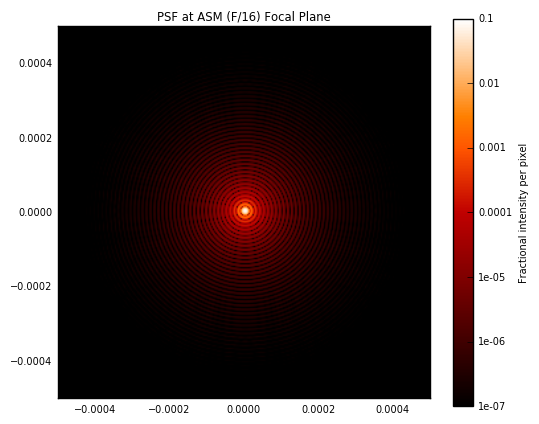

In [40]:
plt.figure(figsize=[6,5])
poppy.display_PSF(asm_psf, imagecrop=0.001)
plt.title("PSF at ASM (F/16) Focal Plane")

### Build to F/57 Focal Plane (Surface 5)

In [41]:
# Surface 2: OAP-2
magaox.add_optic(OAP2, distance=d_asmfp_oap2)
magaox.add_optic(poppy.CircularAperture(radius=oap_radius,name="OAP-2 aperture"))

# Surface 3: tweeter mirror
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="tweeter mirror"), distance=d_oap2_tweeter)
magaox.add_optic(poppy.CircularAperture(radius=oap_radius, name="tweeter mirror aperture"))

# SKIP: ADC1 at Surface 4&5

# Surface 4: OAP-3
magaox.add_optic(OAP3, distance=d_tweeter_oap3)
magaox.add_optic(poppy.CircularAperture(radius=oap_radius,name="OAP-3 aperture"))

# Surface 5: ASM F/57 Focal Plane
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="F/57 Focal Plane (uncorrected)"), distance=d_oap3_f57fp)

### F/57 Focal Plane Correction

In [42]:
# Calculate F/57 focal plane correction distance
unfixed_f57fp_psf, unfixed_f57fp_wfs = magaox.calcPSF(wavelength=testWavelength, display_intermediates=False, return_intermediates=True)
f57_last_wave = unfixed_f57fp_wfs[-1]
f57_delta = f57_last_wave.z_w0 - f57_last_wave.z #f11_delta is the change in distance to compensate the gaussian beam waist.

# Incorporate the correction distance to see the F/11 PSF.
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="F/57 focal plane (corrected)"), distance=f57_delta)

Show F/58 Focal Plane Correction distance:

In [43]:
f57_delta

<Quantity -6.7597240445138596e-06 m>

### F/57 PSF

In [44]:
matplotlib.rcParams["font.size"]=7
plt.figure(figsize=[12,14])
f57_psf, f57_wfs = magaox.calcPSF(wavelength=testWavelength, display_intermediates=False, return_intermediates=True)

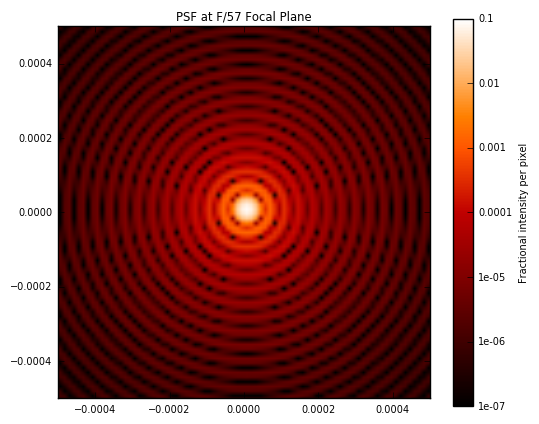

In [45]:
plt.figure(figsize=[6,5])
poppy.display_PSF(f57_psf, imagecrop=0.001)
plt.title("PSF at F/57 Focal Plane")

### Build to F/69 Focal Plane (Surface 13)

In [46]:
# Surface 6: OAP-4
magaox.add_optic(OAP4, distance=d_f57fp_oap4)
magaox.add_optic(poppy.CircularAperture(radius=oap_radius,name="OAP-4 aperture"))

# SKIP: ADC1 (Surface 7&8), ADC2 (Surface 9&10)

# Surface 11: flat TT mirror (9mm pupil)
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="9mm pupil flat TT mirror"), distance=d_oap4_ttmirror)
magaox.add_optic(poppy.CircularAperture(radius=0.0045*u.m, name="woofer mirror aperture"))

# Surface 12: OAP-5.1
magaox.add_optic(OAP5, distance=d_ttmirror_oap51)
magaox.add_optic(poppy.CircularAperture(radius=oap_radius,name="OAP-5 #1 aperture"))

# Surface 13: F/69 Focal Plane
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="F/69 Focal Plane (uncorrected)"), distance=d_oap51_f69fp)

### F/69 Focal Plane Correction

In [47]:
# Calculate F/69 focal plane correction distance
unfixed_f69fp_psf, unfixed_f69fp_wfs = magaox.calcPSF(wavelength=testWavelength, display_intermediates=False, return_intermediates=True)
f69_last_wave = unfixed_f69fp_wfs[-1]
f69_delta = f69_last_wave.z_w0 - f69_last_wave.z #f11_delta is the change in distance to compensate the gaussian beam waist.

# Incorporate the correction distance to see the F/11 PSF.
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="F/69 focal plane (corrected)"), distance=f69_delta)

Show F/69 Focal Plane Correction distance:

In [48]:
f69_delta

<Quantity -2.5852557012484567e-05 m>

### F/69 PSF

In [49]:
matplotlib.rcParams["font.size"]=7
plt.figure(figsize=[10,14])
f69_psf, f69_wfs = magaox.calcPSF(wavelength=testWavelength, display_intermediates=False, return_intermediates=True)

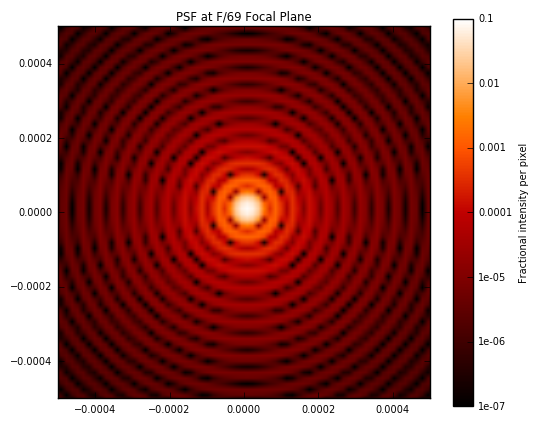

In [50]:
plt.figure(figsize=[6,5])
poppy.display_PSF(f69_psf, imagecrop=0.001)
plt.title("PSF at F/69 Focal Plane")

### Build to Science F/69 Focal Plane

In [51]:
# Surface 14: OAP-5.2
magaox.add_optic(OAP5, distance=d_f69fp_oap52)
magaox.add_optic(poppy.CircularAperture(radius=oap_radius,name="OAP-5 #2 aperture"))

# Surface 15: 9mm Lyot Stop
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="9mm Lyot Stop"), distance=d_oap52_lyot)
magaox.add_optic(lyotstop)

# Surface 16: OAP-5.3
magaox.add_optic(OAP5, distance=d_lyot_oap53)
magaox.add_optic(poppy.CircularAperture(radius=oap_radius,name="OAP-5 #3 aperture"))

# Surface 17: Science F/69 Focal Plane
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="F/69 science Focal Plane (uncorrected)"), distance=d_oap53_f69sci)

### Science F/69 Focal Plane Correction

In [52]:
# Calculate F/69sci focal plane correction distance
unfixed_f69scifp_psf, unfixed_f69scifp_wfs = magaox.calcPSF(wavelength=testWavelength, display_intermediates=False, return_intermediates=True)
f69sci_last_wave = unfixed_f69scifp_wfs[-1]
f69sci_delta = f69sci_last_wave.z_w0 - f69sci_last_wave.z 

# Incorporate the correction distance to see the F/11 PSF.
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="F/69 science focal plane (corrected)"), distance=f69sci_delta)

Science F/69 Focal Plane Correction distance:

In [53]:
f69sci_delta

<Quantity -2.584825261919832e-05 m>

## MagAO-X Optical Element Phase Values

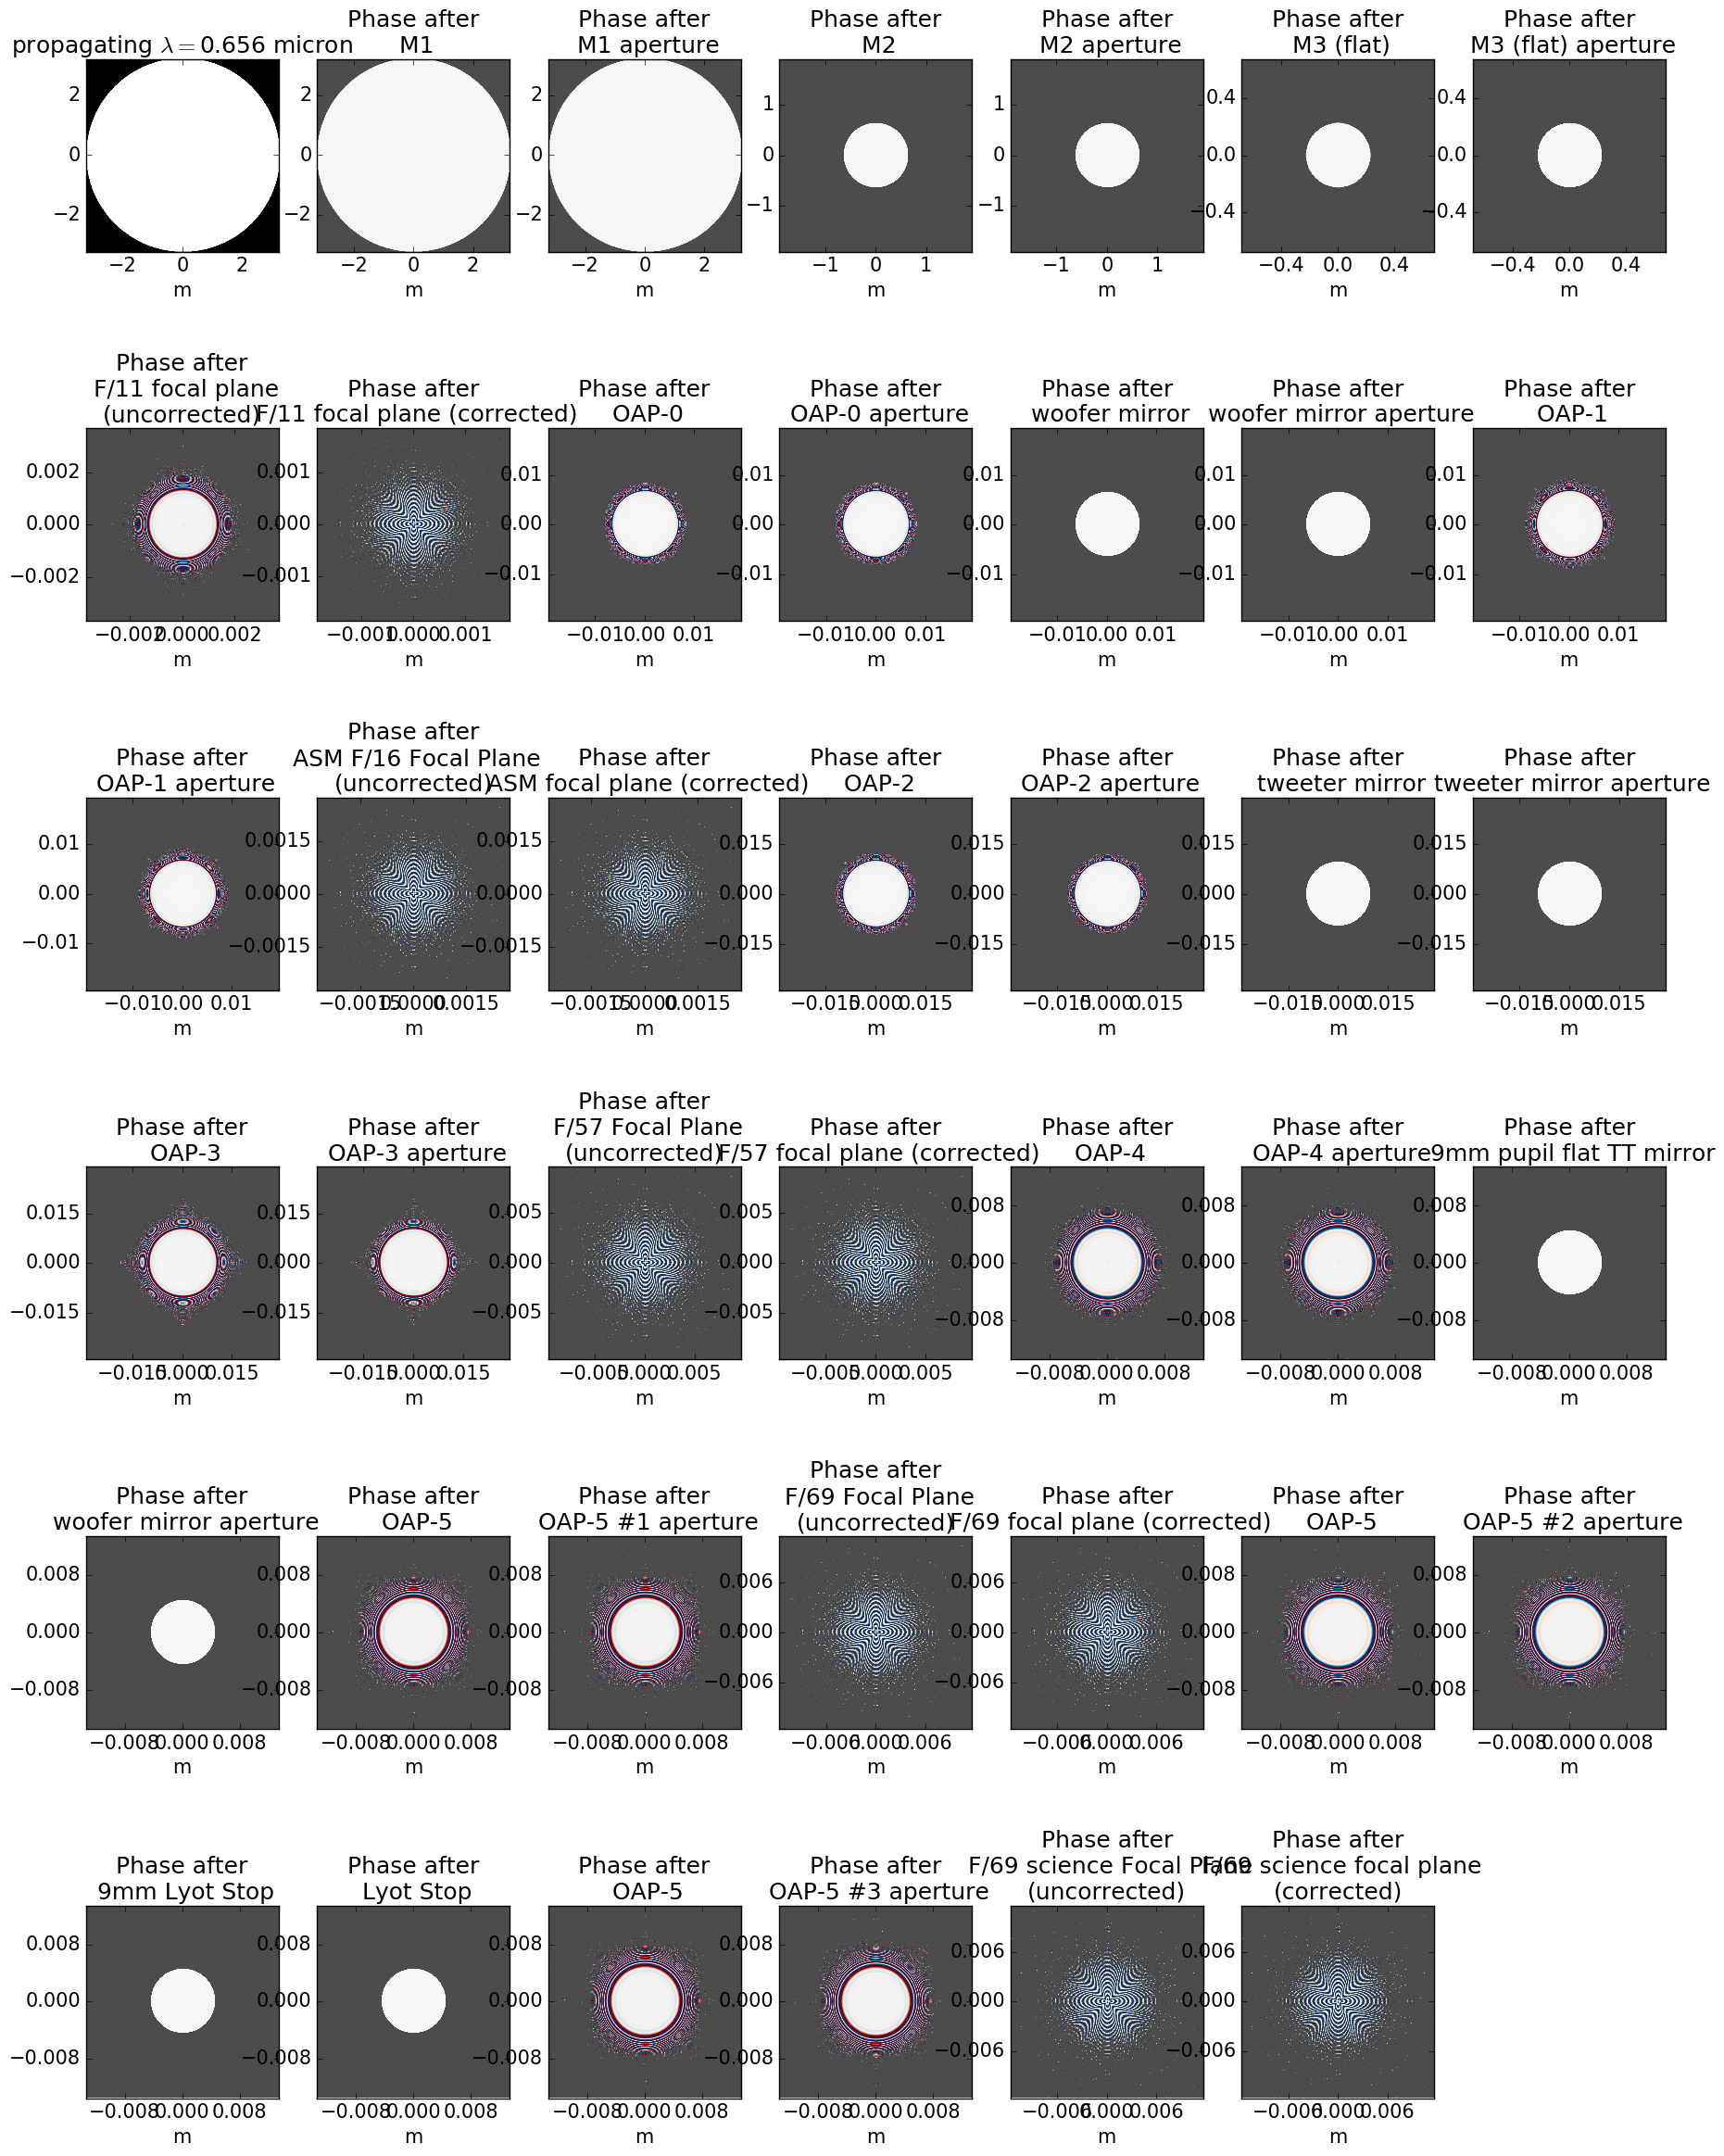

In [54]:
matplotlib.rcParams["font.size"]=15
plt.figure(figsize=[22,30])
f69sci_psf, f69sci_wfs = magaox.calcPSF(wavelength=testWavelength, display_intermediates=True, return_intermediates=True)

## Science F/69 PSF

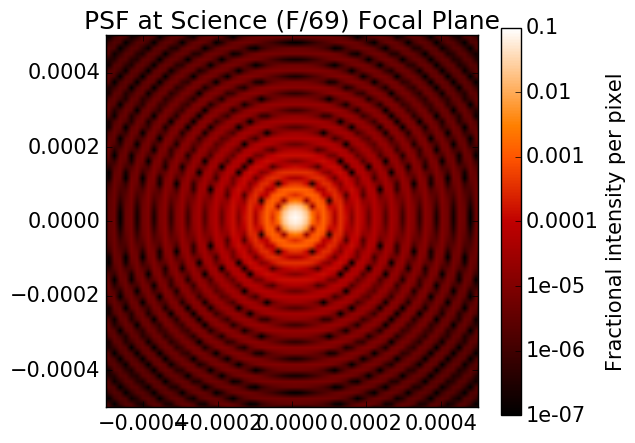

In [57]:
plt.figure(figsize=[6,5])
poppy.display_PSF(f69sci_psf, imagecrop=0.001)
plt.title("PSF at Science (F/69) Focal Plane")

## MagAO-X System Description

In [56]:
magaox.describe()

	Entrance pupil diam:  6.478408 m	npix: 512	Beam ratio:0.34
	Optic: Circle, radius=3.239204 m
	Lens: M1, with focal length 8.128 m
	Optic: M1 aperture
	Propagation distance:  9.72205 m
	Lens: M2, with focal length 1.43141 m
	Optic: M2 aperture
	Propagation distance:  9.02279 m
	Optic: M3 (flat)
	Optic: M3 (flat) aperture
	Propagation distance:  4.979516 m
	Optic: F/11 focal plane (uncorrected)
	Propagation distance:  0.027078593970912834 m
	Optic: F/11 focal plane (corrected)
	Propagation distance:  0.1434399617 m
	Lens: OAP-0, with focal length 0.1434399616742 m
	Optic: OAP-0 aperture
	Propagation distance:  0.14437519 m
	Optic: woofer mirror
	Optic: woofer mirror aperture
	Propagation distance:  0.2107263437 m
	Lens: OAP-1, with focal length 0.2107263436959 m
	Optic: OAP-1 aperture
	Propagation distance:  0.2107263437 m
	Optic: ASM F/16 Focal Plane (uncorrected)
	Propagation distance:  -2.2925479825630646e-07 m
	Optic: ASM focal plane (corrected)
	Propagation distance:  0.3136327727 